In [1]:
from google.colab import drive
drive.mount('/content/drive')

# 0.1 - General Purpose Libraries/Modules

# for linear algebra
import numpy as np
# for data processing and file I/O
import pandas as pd
# for plotting
import matplotlib.pyplot as plt
import seaborn as sns
# for measuring latency
import time

# for data preparation
from sklearn.model_selection import train_test_split
# for scaling
from sklearn.preprocessing import StandardScaler
# for balancing the loss function (the dataset is imbalanced)
from sklearn.utils.class_weight import compute_class_weight
from xgboost import  XGBClassifier
from sklearn.ensemble import RandomForestClassifier
# for evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# 0.2 - The CNN architecture is implemented via keras

# basic configuration
import tensorflow as tf
from tensorflow import keras

# for the implemantation of the models
from keras import layers, Sequential

# for readability purposes
from keras.models import Model
from keras.layers import Dense, Reshape, Concatenate, Conv2D, GlobalAveragePooling2D
from keras.layers import Input,BatchNormalization, MaxPooling2D, Flatten, Dropout

# for the customization of the model and the training process
from keras.callbacks import EarlyStopping, ReduceLROnPlateau


In [3]:
def train_val_test_split(df, rstate=42, shuffle=True, stratify=None):
    strat = df[stratify] if stratify else None
    train_set, test_set = train_test_split(
        df, test_size=0.4, random_state=rstate, shuffle=shuffle, stratify=strat)
    strat = test_set[stratify] if stratify else None
    val_set, test_set = train_test_split(
        test_set, test_size=0.5, random_state=rstate, shuffle=shuffle, stratify=strat)
    return (train_set, val_set, test_set)

In [4]:
def get_feature_importances_rf (_data, _target):
  RFC = RandomForestClassifier(random_state=10, n_jobs=1) # 100 trees in forest
  RFC.fit(_data, _target)
  score = np.round(RFC.feature_importances_,5)
  _importances = pd.DataFrame({'features':_data.columns,'level of importance':score})
  _importances = _importances.sort_values('level of importance',ascending=False).set_index('features')
  return _importances


def get_feature_importances_xgb(_data, _target):
  XGB = XGBClassifier(n_estimators=100, max_depth=3, learning_rate=0.1, missing=np.inf)
  XGB.fit(_data, _target)
  score = np.round(XGB.feature_importances_,5)
  _importances = pd.DataFrame({'features':_data.columns,'level of importance':score})
  _importances = _importances.sort_values('level of importance',ascending=False).set_index('features')
  return _importances

In [5]:
# Custom F1-Score Metric
class F1ScoreMetric(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1ScoreMetric, self).__init__(name=name, **kwargs)
        self.precision = self.add_weight(name='precision', initializer='zeros')
        self.recall = self.add_weight(name='recall', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.cast(tf.greater_equal(y_pred, 0.5), tf.int32)
        y_true = tf.cast(y_true, tf.int32)

        tp = tf.reduce_sum(tf.cast(y_true * y_pred, tf.float32))
        fp = tf.reduce_sum(tf.cast((1 - y_true) * y_pred, tf.float32))
        fn = tf.reduce_sum(tf.cast(y_true * (1 - y_pred), tf.float32))

        precision = tp / (tp + fp + tf.keras.backend.epsilon())
        recall = tp / (tp + fn + tf.keras.backend.epsilon())

        self.precision.assign(precision)
        self.recall.assign(recall)

    def result(self):
        precision = self.precision
        recall = self.recall
        return 2 * ((precision * recall) / (precision + recall + tf.keras.backend.epsilon()))

    def reset_states(self):
        self.precision.assign(0)
        self.recall.assign(0)

In [6]:
# 0.3 - Reproducibility Establishment

# Set seed
seed = 314159

# Set numpy seed
np.random.seed(seed)
# Set the seed for TensorFlow
tf.random.set_seed(seed)

In [7]:
ds = "/content/drive/My Drive/THESIS/Notebook/df_575000.csv"

In [8]:
df_data  = pd.read_csv(ds)
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 575000 entries, 0 to 574999
Data columns (total 79 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Destination Port             575000 non-null  int64  
 1   Flow Duration                575000 non-null  int64  
 2   Total Fwd Packets            575000 non-null  int64  
 3   Total Backward Packets       575000 non-null  int64  
 4   Total Length of Fwd Packets  575000 non-null  int64  
 5   Total Length of Bwd Packets  575000 non-null  int64  
 6   Fwd Packet Length Max        575000 non-null  int64  
 7   Fwd Packet Length Min        575000 non-null  int64  
 8   Fwd Packet Length Mean       575000 non-null  float64
 9   Fwd Packet Length Std        575000 non-null  float64
 10  Bwd Packet Length Max        575000 non-null  int64  
 11  Bwd Packet Length Min        575000 non-null  int64  
 12  Bwd Packet Length Mean       575000 non-null  float64
 13 

In [9]:
df_data['Label'] = df_data.loc[:, "Label"].map(lambda lbl: 0 if lbl == "BENIGN" else 1)

In [10]:
df_data.head()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,53,31318,2,2,72,392,36,36,36.000000,0.000000,...,32,0.00000,0.0000,0,0,0.0,0.00000,0,0,0
1,80,98003692,7,5,366,11595,366,0,52.285714,138.334997,...,32,5.00000,0.0000,5,5,98000000.0,0.00000,98000000,98000000,1
2,443,116595575,22,18,823,4049,472,0,37.409091,108.335748,...,32,89777.45455,220894.0786,755798,22989,10200000.0,63666.75161,10200000,10000000,0
3,53,32041,2,2,88,200,44,44,44.000000,0.000000,...,32,0.00000,0.0000,0,0,0.0,0.00000,0,0,0
4,80,50370,1,1,0,0,0,0,0.000000,0.000000,...,32,0.00000,0.0000,0,0,0.0,0.00000,0,0,0


In [11]:
# Discarding NA values.
# Replace infinite updated data with nan
df_data.replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop rows with NaN
df_data.dropna(inplace=True)
df_data.shape

(574404, 79)

In [12]:
all_zeroes_cols = df_data.loc[:,(df_data.iloc[1:] == 0).all()]
df_data.drop(columns=all_zeroes_cols, inplace=True)
df_data.shape

(574404, 71)

In [13]:
## feature selection phase - prepare data for RFC
#lbls = all_datav2.loc[:, "Label"]
data_w_o_cat_attrs = df_data.iloc[:, :-1]
#lbls
data_w_o_cat_attrs.shape

(574404, 70)

In [14]:
lbls = df_data.loc[:, "Label"] #"Label"
lbls.shape

(574404,)

In [15]:
use_rf = False
importances = None
if use_rf:
  importances = get_feature_importances_rf(data_w_o_cat_attrs, lbls)

else:
  importances = get_feature_importances_xgb(data_w_o_cat_attrs, lbls)

importances

,level of importance
features,
Bwd Header Length,0.17378
Average Packet Size,0.15864
Bwd Packet Length Std,0.15401
Max Packet Length,0.08156
Bwd Packet Length Min,0.04441
...,...
RST Flag Count,0.00000
Flow Packets/s,0.00000
Fwd URG Flags,0.00000


In [16]:
threshold = 0.001 # importance threshold
bl_thresh = importances.loc[importances["level of importance"] < threshold]
print("there are {} features to delete, as they are below chosen threshold".format(bl_thresh.shape[0]))
print("these features are the following:")
feats_to_del = [feat for feat in bl_thresh.index]
print("\n".join(feats_to_del))

there are 26 features to delete, as they are below chosen threshold
these features are the following:
Bwd IAT Std
Fwd IAT Std
Fwd Packet Length Mean
Bwd IAT Min
Total Backward Packets
URG Flag Count
Active Max
Bwd IAT Total
Subflow Bwd Bytes
Idle Std
Active Mean
Idle Max
Fwd Header Length.1
Subflow Bwd Packets
Subflow Fwd Bytes
Subflow Fwd Packets
Avg Bwd Segment Size
Avg Fwd Segment Size
Bwd IAT Max
ECE Flag Count
CWE Flag Count
RST Flag Count
Flow Packets/s
Fwd URG Flags
Packet Length Variance
SYN Flag Count


In [17]:
## removing these not important features
df_data.drop(columns=feats_to_del, inplace=True)
df_data.shape

(574404, 45)

In [18]:
X = df_data.drop(['Label'], axis=1).values
y = df_data['Label'].values

In [19]:
# Normalize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [20]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


In [21]:
# Step 3: Build the CNN Model
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_train.shape[1], 1)),  # Input layer
    tf.keras.layers.Conv1D(32, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Conv1D(64, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Output layer
])

In [22]:
# Step 4: Compile the Model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[F1ScoreMetric()]) # 'f1_score'

In [23]:
# Step 5: Train the Model
X_train = X_train.reshape(-1, X_train.shape[1], 1)  # Reshape for Conv1D
X_val = X_val.reshape(-1, X_val.shape[1], 1)


In [24]:
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=20,
                    batch_size=32)

Epoch 1/20
12566/12566 ━━━━━━━━━━━━━━━━━━━━ 46s 4ms/step - f1_score: 0.1949 - loss: 0.1191 - val_f1_score: 0.1765 - val_loss: 0.0547
Epoch 2/20
12566/12566 ━━━━━━━━━━━━━━━━━━━━ 81s 3ms/step - f1_score: 0.1977 - loss: 0.0612 - val_f1_score: 0.1765 - val_loss: 0.0525
Epoch 3/20
12566/12566 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - f1_score: 0.1980 - loss: 0.0537 - val_f1_score: 0.1765 - val_loss: 0.0471
Epoch 4/20
12566/12566 ━━━━━━━━━━━━━━━━━━━━ 40s 3ms/step - f1_score: 0.1985 - loss: 0.0496 - val_f1_score: 0.1765 - val_loss: 0.0439
Epoch 5/20
12566/12566 ━━━━━━━━━━━━━━━━━━━━ 44s 3ms/step - f1_score: 0.1987 - loss: 0.0453 - val_f1_score: 0.1765 - val_loss: 0.0464
Epoch 6/20
12566/12566 ━━━━━━━━━━━━━━━━━━━━ 80s 3ms/step - f1_score: 0.1988 - loss: 0.0434 - val_f1_score: 0.1765 - val_loss: 0.0415
Epoch 7/20
12566/12566 ━━━━━━━━━━━━━━━━━━━━ 43s 3ms/step - f1_score: 0.1989 - loss: 0.0427 - val_f1_score: 0.1765 - val_loss: 0.0362
Epoch 8/20
12566/12566 ━━━━━━━━━━━━━━━━━━━━ 40s 3ms/step - f1_score: 

In [25]:
# Step 6: Evaluate the Model
X_test = X_test.reshape(-1, X_test.shape[1], 1)
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test F1-score: {test_acc:.2f}")

2693/2693 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - f1_score: 0.2007 - loss: 0.0342
Test Accuracy: 0.12


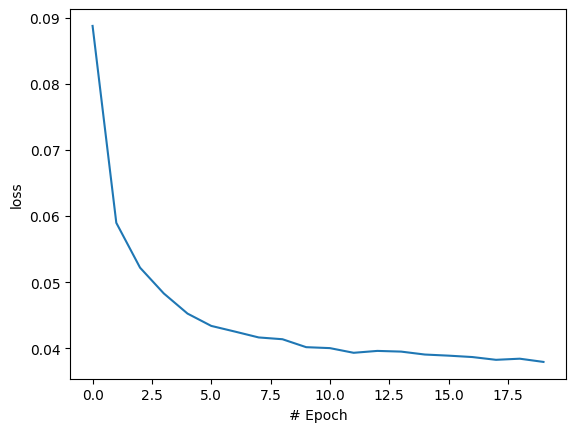

In [26]:
plt.xlabel("# Epoch")
plt.ylabel("loss")
plt.plot(history.history["loss"])

In [27]:
# Get Predictions
y_pred = model.predict(X_test)
y_pred_binary = (y_pred >= 0.5).astype(int)

2693/2693 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


In [28]:
f1 = f1_score(y_test, y_pred_binary)
print(f"Test F1-Score: {f1:.2f}")

Test F1-Score: 0.96
